## Prologue

<i> A Note from Shellakybooky Holmes (September 1st, 1930) </i>

This past summer, Dr. Jahnvi Watson and I were spending some time in Monte Carlo at the Hotel Hamilton for what you might call "a vacation". In truth, I was honing my renowned skills of deduction while Watson went about her activities. I was engaged in becoming familiar with a school of statistical thinking, the Bayesian methodology of inference and analysis. There are remarkable methods within this school that are perfectly suited to my needs as a detective and man of science. Hence I spent many a summer day training my mind palace in the implementation of these methods so as to employ it most effectively whenever the need arose. And as luck would have it, such a need arose! The murder of Count Frick Von Twist provided an ideal testing ground for these methods and I have chronicled the details of the case and the subsequent resolution here.

As is the case with most explanations, once it is grasped it seems almost trivial, a phenomenon that annoys me immensely! Like a magician's carefully constructed sleight of hand, to reveal one's tricks is to expose oneself to ridicule and trivialization. Nonetheless, upon my friend's insitence, I shall endeavour to provide you with such an explanation with a view to make them seem elementary to you as well. But be not fooled, my dear reader, as the apparent simplicity of these methods bely an underlying sophistication that can only be grasped at with sufficient practice. It is my hope thus that the analysis presented here inspires many an amateur enthusiast of the science of deduction (such as my dear friend Watson herself) to embrace these marvelous methods whenever they are in need of infering information from data. 

## 1. The game is afoot!

In [1]:
#Importing the usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

(<i>To run the following lines of code you will have to install pymc3. If you haven't already, uncomment the following cell to do so!</i>)

In [2]:
#!pip install pymc3

In [3]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import seaborn as sns

Space to describe the problem along with shots of each character.

In [4]:
suspect_names = ['Viscountess Bae Zhun',  'Major Viktor Ljutenitsa', 'Ms Ingrid Hepburn', 
                 'Lord Bryce Bloomington', 'Barrister Shannon Von Twist', 'Nurse Eliza Dill', 
                 'Lady Barbara Bloomington', 'Mr. Miles Murdoch', 'Mr. Stan Hamilton','Python']

I instructed Watson to interview each of the guests separately and take down detailed notes. In particular I asked her to jot down the responses to each of the following questions. <br>

1. Is there an alibi for the suspect? (0/1)
2. Did they benefit from the Count’s will? (0/1) 
3. How are their archery skills? (0/1) 
4. Does anyone else suspect them? (0/1)
5. Did they have animosity towards the Count? (0/1)

Some of these are absolute requirements for the murder (alibi and archery skill for instance) and the others, possibly highly correlated with the same. Perhaps Watson would have preferred to write these down on a spectrum of values, but the simplest approach would be to assign a 1 or a 0 to each suspect. 
(<i>1, being the value correlated with murder and 0 the opposite. Thus, for instance absence of a valid alibi would correspond to 1 and whether they have been trained in archery would correspond to 1 as well.</i>)



## 2. Watson Interviews

In [5]:
df = pd.read_csv('WatsonNotebook/1_Watson_Interviews.csv')
df

,suspects,alibi,archery,inheritance,suspicion,animosity
0,Viscountess Bae Zhun,0,1,1,1,1
1,Major Viktor Ljutenitsa,0,1,0,1,0
2,Ms Ingrid Hepburn,1,1,0,1,0
3,Lord Bryce Bloomington,0,1,0,1,1
4,Barrister Shannon Von Twist,0,1,0,1,0
5,Nurse Eliza Dill,1,1,0,1,0
6,Lady Barbara Bloomington,1,0,0,0,0
7,Mr. Miles Murdoch,1,0,0,0,1
8,Mr. Stan Hamilton,0,0,1,1,1
9,Python,1,0,0,0,0


In [6]:
proxies = df.columns[1:]
proxies

Index(['alibi', 'archery', 'inheritance', 'suspicion', 'animosity'], dtype='object')

### A model choice

Watson's meticulous compilation of the above data sets us up very well indeed to be able to tackle the problem. What can we glean from a table of 0's and 1's? Well for one, we can already see the variance in the number of ones in some of the rows (i.e., between the different suspects). However, to approach this more rigorously, I propose a model belonging to the group of models known as Rasch model (or an [Item Response Model](https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html)).

Let's say each individual has a latent culpability $\alpha$ and that each so-called "murder proxy" has a latent measure of ease (or difficulty) among the group, $\beta$ (For instance, it could be that many people are skilled archers or very few people have alibis, etc.) We propose the following equation to describe the probability that a suspect $j$ is culpable in murder proxy $k$:

$$ P(y_{j,k} = 1) = \hbox{logit}^{-1}(\alpha_{j} + \beta_{k}) $$

We have 10 suspects here and 5 murder proxies and so $j$ takes from 0,1,..,9 and $k$, from 0,1..,4 to keep pythonic indexing here. The [inverse logit](https://en.wikipedia.org/wiki/Logit) function is a natural choice for binary predictions and represents the logarithm of odds. Simply put, the higher the $\alpha$ and $\beta$ for a particular suspect-proxy (j,k) pair, the greater the odds of their culpability within that context.

### Assigning priors

Once we have specified a model, we would now like to consider the question of priors. Of course we intend to infer the fifteen latent measures described above, but we must consider what these numbers could be before moving forward, i.e., we must assign them prior distributions that quantify our knowledge thusfar.  

I did ask Watson to also note down her subjective suspicions of everyone - I verily do trust her excellent intuition but she (bless her soul!) is more innately trusting in the goodness of human nature than I would like my model to be at this very moment. Besides, it is early in this game of cat and mouse and so I am going to set those numbers aside for now and instead consider the same prior for each suspect - a normal distribution centred on 0 and with a standard deviation of 1. With **PyMC3**, it is as simple as writing down the following:

In [7]:
sample_distribution = pm.Normal.dist(0,1)

What would such a prior look like? We're going to draw 10000 samples from this distribution and plot it to get an idea! The X-axis below represents the value of culpability for each suspect and the Y-Axis gives us a measure of how likely it is that the value gets drawn from the distribution. Thus, here, the priors are centred at zero, i.e., we really are giving each suspect a fair chance. Once we have run our simluations, we will get the <b> posterior</b> which likely will not be centred at zero for each suspect, indicating which direction their culpability might tend to - but more on that later!

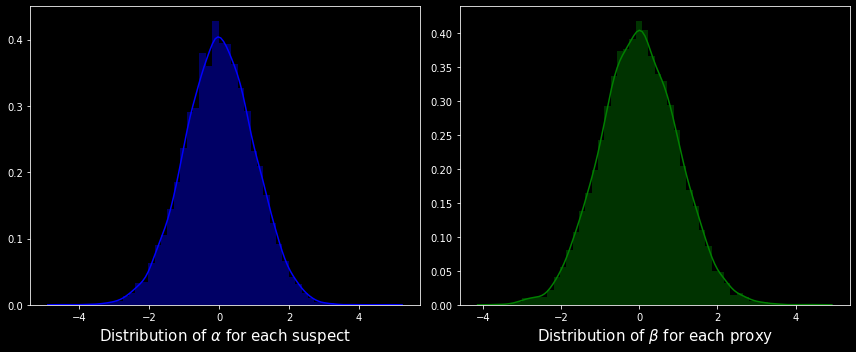

In [9]:
with plt.style.context('dark_background'):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
    sns.distplot(sample_distribution.random(size = 10000), color = 'b', ax = ax1)
    sns.distplot(sample_distribution.random(size = 10000), color = 'g', ax = ax2)
    ax1.set_xlabel(r'Distribution of $\alpha$ for each suspect', fontsize =15)
    ax2.set_xlabel(r'Distribution of $\beta$ for each proxy', fontsize =15)
    plt.tight_layout()
    plt.savefig('./images/bell_curve_prior_alpha_beta.png')
    plt.show()

It is worth keeping in mind that we're keeping the same distribution for all the suspect culpabilities and the murder proxies. 

### Writing the model

Now that we know how to ascribe priors to our parameters, we're going to incorporate this into our model as follows:

In [10]:
n_suspects = 10
n_proxies = 5
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu = 0, sd = 1, shape=n_suspects)
    beta = pm.Normal('beta', mu=0, sd=1, shape=n_proxies)

Before we begin sampling, we would like our data from above and transform it to one that has only 3 columns:<br><b>Suspect Number</b>, <br>
<b>Murder Proxy Number</b> and <br> 
<b>Value</b> (i.e., 0 or 1). <br>
It's a quick call to one of the functions (among others) I wrote on the back of an envelope that will let us do this:

In [11]:
from BackOfTheEnvelope.helpers import transform_df, get_results
observed_data = transform_df(df).reset_index(drop = True)
observed_data.head(10)

,suspects,murder_proxy,value
0,0,0,0
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,1,0,0
6,1,1,1
7,1,2,0
8,1,3,1
9,1,4,0


In [12]:
with model:
    idx1 = observed_data.suspects.values
    idx2 = observed_data.murder_proxy.values
    contextual_culpability= pm.Deterministic('contextual_culpability', alpha[idx1] + beta[idx2]) 
    theta = pm.Deterministic('theta', pm.math.sigmoid(contextual_culpability))

## 3. The Mind Palace

At this point, I had all the tools needed to enter my mind palace where I will, with some very efficient searching of the parameter space, come up with the posterior distribution that fits the data best. Consider the following:

In [13]:
with model:
    y = pm.Bernoulli('y', theta ,observed = observed_data['value'])

In [14]:
with model:
    trace = pm.sample(2000, tune=2000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:15<00:00, 1029.08draws/s]


In [15]:
summarystats = pm.summary(trace)

In [16]:
results = get_results(trace)
results

,suspects,mean_alpha,alpha_hpd3,alpha_hpd97
0,Viscountess Bae Zhun,0.776,-0.602,2.103
1,Major Viktor Ljutenitsa,-0.220,-1.621,1.080
2,Ms Ingrid Hepburn,0.267,-1.118,1.575
3,Lord Bryce Bloomington,0.268,-1.061,1.636
4,Barrister Shannon Von Twist,-0.234,-1.523,1.202
5,Nurse Eliza Dill,0.280,-1.015,1.631
6,Lady Barbara Bloomington,-0.732,-2.128,0.579
7,Mr. Miles Murdoch,-0.227,-1.535,1.173
8,Mr. Stan Hamilton,0.274,-1.155,1.569
9,Python,-0.734,-2.167,0.602


### A peek at the posteriors

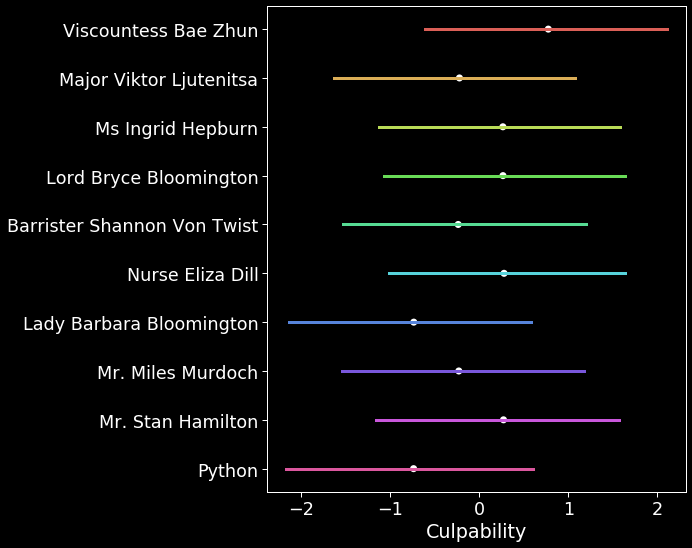

In [18]:
with plt.style.context('dark_background'):
    sns.set_context("paper", font_scale= 2)
    plt.style.context('dark_background')
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.pointplot(x="mean_alpha", y="suspects", data=results, join=False, color = 'w', size = 40000)
    ax.set(xlabel='Culpability', ylabel='')
    i = 0
    for row, pair in enumerate(zip(results['alpha_hpd3'], results['alpha_hpd97'])):
        ax.plot(pair, [row,row],color = sns.color_palette("hls",10)[i], lw=3)
        i +=1
    plt.tight_layout()
    plt.savefig('./images/coefplot1.png')
    plt.show()

### How well does the model fit the observed data?

## 4. A Twist in the Tale

In [19]:
df_updated = df.copy()
df_updated['inheritance'] = [0,0,1,0,0,0,0,0,1,0]
df_updated

,suspects,alibi,archery,inheritance,suspicion,animosity
0,Viscountess Bae Zhun,0,1,0,1,1
1,Major Viktor Ljutenitsa,0,1,0,1,0
2,Ms Ingrid Hepburn,1,1,1,1,0
3,Lord Bryce Bloomington,0,1,0,1,1
4,Barrister Shannon Von Twist,0,1,0,1,0
5,Nurse Eliza Dill,1,1,0,1,0
6,Lady Barbara Bloomington,1,0,0,0,0
7,Mr. Miles Murdoch,1,0,0,0,1
8,Mr. Stan Hamilton,0,0,1,1,1
9,Python,1,0,0,0,0


In [20]:
observed_data_updated = transform_df(df_updated)

In [21]:
posterior_alpha_means = summarystats['mean'][0:10].values
posterior_alpha_sds = summarystats['sd'][0:10].values
posterior_beta_means = summarystats['mean'][10:15].values
posterior_beta_sds = summarystats['sd'][10:15].values
posterior_alpha_means, posterior_alpha_sds

(array([ 0.776, -0.22 ,  0.267,  0.268, -0.234,  0.28 , -0.732, -0.227,
         0.274, -0.734]),
 array([0.736, 0.716, 0.718, 0.717, 0.719, 0.709, 0.726, 0.717, 0.723,
        0.732]))

In [23]:
with pm.Model() as model:
    alpha_updated = pm.Normal('alpha', posterior_alpha_means, posterior_alpha_sds, shape = 10)
    beta_updated = pm.Normal('beta', 0,1)
    idx1 =[0,1,2,3,4,5,6,7,8,9]
    #idx2 = observed_data_new.murder_proxy.values
    contextual_culpability= pm.Deterministic('contextual_culpability', alpha_updated[idx1] + beta_updated) 
    theta = pm.Deterministic('theta', pm.math.sigmoid(contextual_culpability))
    y = pm.Bernoulli('y', theta ,observed = df_updated['inheritance'].values)
    trace_updated = pm.sample(2000, tune=2000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:15<00:00, 1010.86draws/s]


In [24]:
results_updated = get_results(trace_updated)
results_updated

,suspects,mean_alpha,alpha_hpd3,alpha_hpd97
0,Viscountess Bae Zhun,0.554,-0.749,1.872
1,Major Viktor Ljutenitsa,-0.338,-1.603,0.968
2,Ms Ingrid Hepburn,0.566,-0.643,1.880
3,Lord Bryce Bloomington,0.107,-1.158,1.409
4,Barrister Shannon Von Twist,-0.362,-1.605,0.945
5,Nurse Eliza Dill,0.119,-1.161,1.403
6,Lady Barbara Bloomington,-0.818,-2.093,0.534
7,Mr. Miles Murdoch,-0.355,-1.690,0.908
8,Mr. Stan Hamilton,0.592,-0.725,1.831
9,Python,-0.824,-2.129,0.426


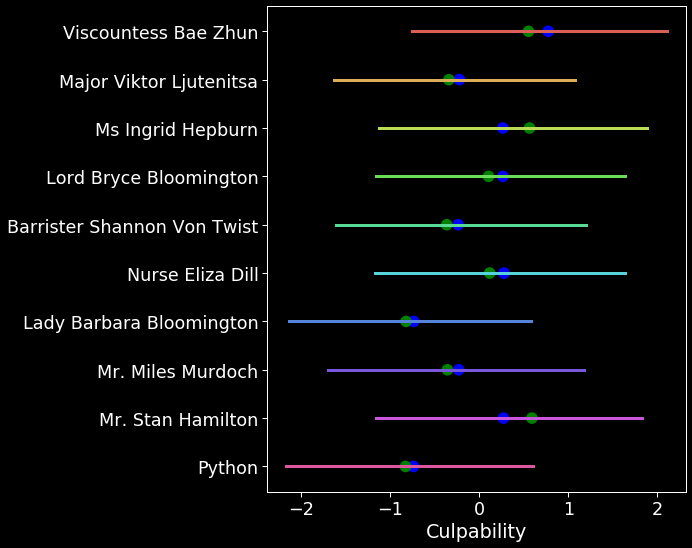

In [25]:
with plt.style.context('dark_background'):
    sns.set_context("paper", font_scale= 2)
    plt.style.context('dark_background')
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.pointplot(x="mean_alpha", y="suspects", data=results, join=False, color = 'b', size = 40000, label = 'before')
    ax = sns.pointplot(x="mean_alpha", y="suspects", data=results_updated, join=False, color = 'g', size = 40000, label = 'after')
    #plt.legend(ax)
    ax.set(xlabel='Culpability', ylabel='')
    i = 0
    for row, pair in enumerate(zip(results['alpha_hpd3'], results['alpha_hpd97'])):
        ax.plot(pair, [row,row],color = sns.color_palette("hls",10)[i], lw=3)
        i +=1
    i = 0
    for row, pair in enumerate(zip(results_updated['alpha_hpd3'], results_updated['alpha_hpd97'])):
        ax.plot(pair, [row,row],color = sns.color_palette("hls",10)[i], lw=3)
        i +=1
    plt.setp(ax.collections, sizes=[100])
    
    plt.tight_layout()
    plt.savefig('./images/coefplot2.png')
    plt.show()

## 5. Peace and Convergence

## Final Model Run!

In [26]:
df_final = df.copy()

In [27]:
df_final['alibi'] = [0,0,0,0,0,1,0,1,0,1]
df_final['animosity'] = [0,0,0,1,0,1,0,1,1,0]
df_final['inheritance'] = [1,0,0,0,0,1,0,0,1,0]
df_final.to_csv('./WatsonNotebook/3_peace_and_convergence.csv')

In [28]:
observed_data_final = transform_df(df_final)

In [29]:
n_suspects = 10
n_proxies = 5

In [30]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu = 0, sd = 1, shape=n_suspects)
    beta = pm.Normal('beta', mu=0, sd=1, shape=n_proxies)
    idx1 = observed_data_final.suspects.values
    idx2 = observed_data_final.murder_proxy.values
    contextual_culpability= pm.Deterministic('contextual_culpability', alpha[idx1] + beta[idx2]) 
    theta = pm.Deterministic('theta', pm.math.sigmoid(contextual_culpability))
    y = pm.Bernoulli('y', theta ,observed = observed_data_final['value'])
    trace_final = pm.sample(2000, tune=2000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:19<00:00, 840.09draws/s] 


In [178]:
results_final = get_results(trace_final)
results_final

,suspects,mean_alpha,alpha_hpd3,alpha_hpd97
0,Viscountess Bae Zhun,0.297,-1.062,1.634
1,Major Viktor Ljutenitsa,-0.198,-1.593,1.188
2,Ms Ingrid Hepburn,-0.197,-1.527,1.158
3,Lord Bryce Bloomington,0.299,-1.052,1.645
4,Barrister Shannon Von Twist,-0.187,-1.460,1.245
5,Nurse Eliza Dill,1.346,-0.003,2.799
6,Lady Barbara Bloomington,-1.245,-2.718,0.178
7,Mr. Miles Murdoch,-0.191,-1.551,1.147
8,Mr. Stan Hamilton,0.302,-1.082,1.608
9,Python,-0.708,-2.105,0.618


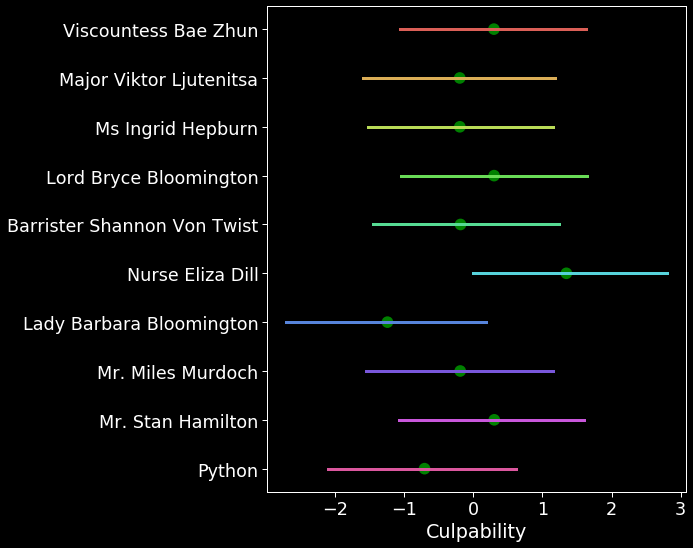

In [179]:
with plt.style.context('dark_background'):
    sns.set_context("paper", font_scale= 2)
    plt.style.context('dark_background')
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.pointplot(x="mean_alpha", y="suspects", data=results_final, join=False, color = 'g', size = 40000, label = 'after')

    ax.set(xlabel='Culpability', ylabel='')
    i = 0
    for row, pair in enumerate(zip(results_final['alpha_hpd3'], results_final['alpha_hpd97'])):
        ax.plot(pair, [row,row],color = sns.color_palette("hls",10)[i], lw=3)
        i +=1
    plt.setp(ax.collections, sizes=[100])
    
    plt.tight_layout()
    plt.savefig('./images/final_graphic.png')
    plt.show()

## Epilogue